In [17]:
from astropy.table import Table
from calc_kcor import calc_kcor
from astropy.cosmology import FlatLambdaCDM
from prefig import Prefig
Prefig()

% matplotlib inline

fig_dir = '../../figures/samples/'
source_dir = '../../fits/'
save_dir = '../../fits/'
source_file = 'full_sample_w_bd.fits'

cosmo=FlatLambdaCDM(H0=70,Om0=0.3) # Use standard cosmology model from astropy.

In [18]:
data = fits.getdata(source_dir + source_file,1)
full_table = Table(data)

select_crit = np.isfinite(full_table['logMt'])

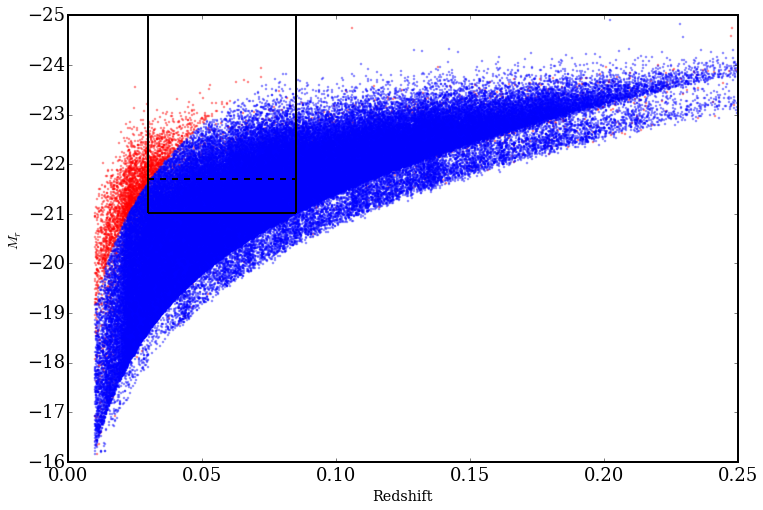

In [19]:
clr = ['r','b']
plt.figure(figsize=(12,8))

for tf in enumerate([False,True]):
    
    table = full_table[select_crit == tf[1]]
    plt.scatter(table['REDSHIFT_1'],table['PETROMAG_MR'],s=3,alpha=0.3,color=clr[tf[0]])
    
plt.xlabel('Redshift')
plt.ylabel('$M_r$')
plt.xlim(0,0.25)
_ = plt.ylim(-16,-25)

plt.hlines(-21.01,0.03,0.085,'k')
plt.vlines(0.03,-21.01,-25,'k')
plt.vlines(0.085,-21.01,-25,'k')
plt.hlines(-21.7,0.03,0.085,'k',linestyle='dashed')

# Missing the brightest galaxies where m_r < 14. Need a way to optimise the 'box'. 

In [20]:
def get_sample_limits(z,table,m_limit=14):

    z_min=[z] # Define the maximum redshift.
    D_min=(10**6)*(np.array(cosmo.luminosity_distance(z_min))[0]) # Define the
    # maximum distance from the max redshift.
    
    k_val = calc_kcor('r',z,'g - r',0.8)
    
    M_limit=m_limit - 5*(math.log10(D_min) - 1) - k_val 

    return z_min,M_limit

In [21]:
def output_vls_sizes(table,N_steps=1000):
    
    z_vals = np.linspace(np.min(table['REDSHIFT_1']),np.max(table['REDSHIFT_1']),N_steps)
    
    sizes=np.zeros((N_steps,2))

    for z in enumerate(z_vals):
        z_min,M_limit = get_sample_limits(z=z[1],table=table)
        select = ((table['PETROMAG_MR'] >= M_limit) 
                  & (table['REDSHIFT_1'] >= z_min))# & (table['mag'] <= 17))
        sizes[z[0],:] = np.array([z[1],np.sum(select)])
  
    sizes = Table(sizes,names=('redshift','N_gal'))
        
    return sizes

best redshift = 0.04354364637498025


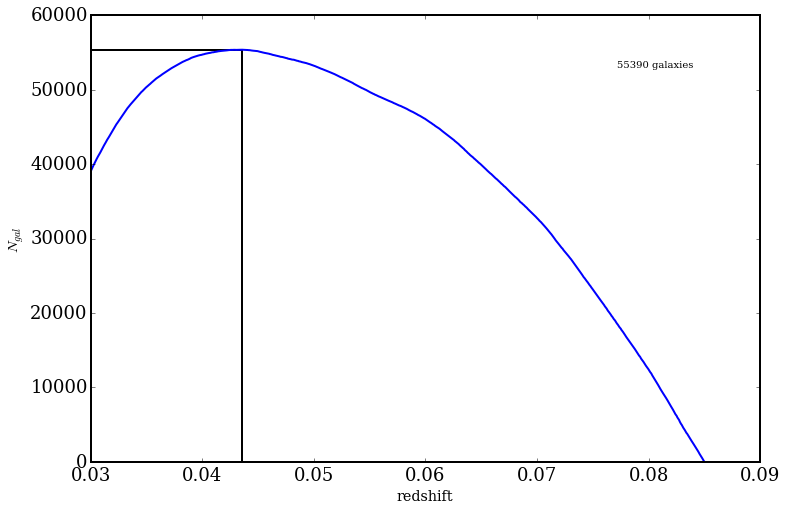

In [22]:
# Set the z-limit at 0.085, vary the lower z-limit:

plt.figure(figsize=(12,8))
ax=plt.subplot(1,1,1)

vol_limited = fits.getdata(source_dir + 'volume_limited_sample_bd.fits',1)
vol_table = Table(vol_limited)

sizes = output_vls_sizes(vol_table)

plt.plot(sizes['redshift'],sizes['N_gal'])
plt.vlines(sizes['redshift'][np.argmax(sizes['N_gal'])],0,np.max(sizes['N_gal']),'k')
plt.hlines(np.max(sizes['N_gal']),0.03,sizes['redshift'][np.argmax(sizes['N_gal'])],'k')
plt.text(0.9,0.9,'{0:0.0f} galaxies'.format(np.max(sizes['N_gal']))
         ,ha='right',va='top',transform=ax.transAxes)

plt.xlabel('redshift')
plt.ylabel('$N_{gal}$')

print('best redshift = {}'.format(sizes['redshift'][np.argmax(sizes['N_gal'])]))

In [23]:
def get_volume_limited_sample(z,vol_table,full_data,maximise=False,plot=False):
    
    if maximise == True:
        sizes = output_vls_sizes(table=data_table)
        z = sizes[np.argmax(sizes['N_gal'])]['redshift']
    
    z_min,M_limit = get_sample_limits(z,table)
    
    select = ((vol_table.field('REDSHIFT_1') >= z_min) 
              & (vol_table.field('PETROMAG_MR')>= M_limit))
    
    if plot == True:
        
        plt.figure(figsize=(16,10))
        ax = plt.subplot(1,1,1)
        
        plt.scatter(full_data.field('REDSHIFT_1'),full_data.field('PETROMAG_MR'),
                 facecolor='red',alpha=0.5,s=3,edgecolor='none')
        
        plt.hlines(M_limit,z_min,0.085,'k')
        plt.hlines(np.max(vol_table['PETROMAG_MR']),z_min,0.085,'k')
        plt.vlines(z_min,M_limit,np.max(vol_table['PETROMAG_MR']),'k')
        plt.vlines(0.085,M_limit,np.max(vol_table['PETROMAG_MR']),'k')
        plt.text(0.9,0.9,'{} galaxies'.format(np.sum(select))
                ,ha='right',va='top',transform=ax.transAxes)
        
        plt.xlabel('redshift')
        plt.ylabel('$M_r$')
        
        plt.xlim([0,0.26])
        plt.ylim([-16,-25])
        plt.savefig(fig_dir + 'BD_volume_limited_sample.pdf',dpi=100)
        
    print('M_r limit = {}, {} galaxies in sample'.format(M_limit,np.sum(select)))
    
    return select

M_r limit = -22.464480714369508, 55385 galaxies in sample


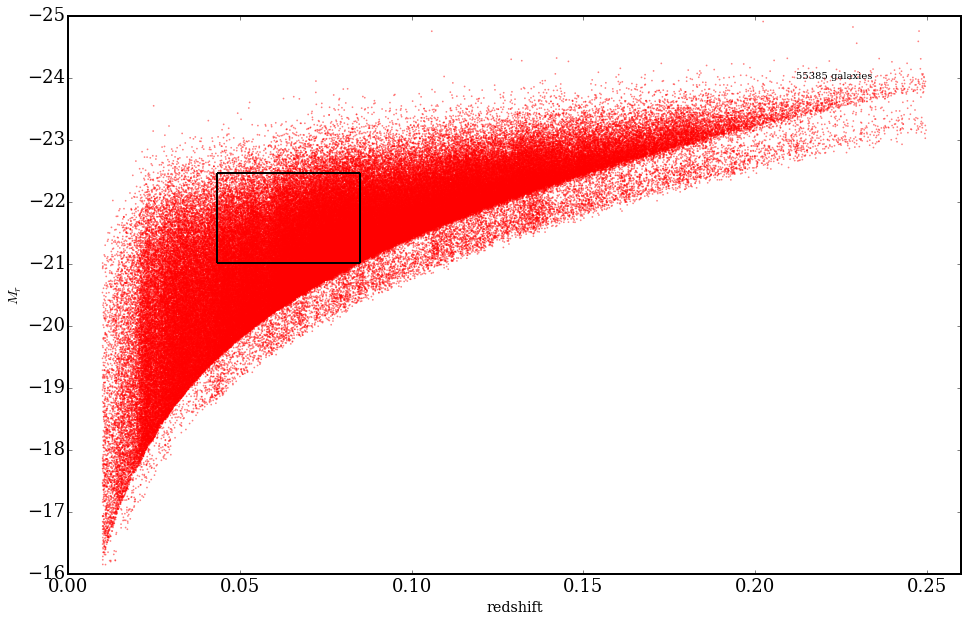

In [31]:
select_vl = get_volume_limited_sample(0.0435,vol_table,data,plot=True)
vl = vol_table[(select_vl) & (np.isfinite(vol_table['logMt']))]

debiased = fits.getdata(source_dir + 'debiased_volume_limited_sample.fits',1)
debiased = Table(debiased)
deb = debiased[(select_vl) & (np.isfinite(vol_table['logMt']))]

vl.write(save_dir + 'BD_volume_limited_sample.fits',overwrite=True)
deb.write(save_dir + 'BD_debiased.fits',overwrite=True)